In [1]:
import tensorflow as tf
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt

from strawberryfields import ops

from qmlt.tf import CircuitLearner
from qmlt.tf.helpers import make_param

from sklearn.utils import shuffle
from sklearn.datasets import load_digits

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1841069384148250975
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 235274240
locality {
  bus_id: 1
}
incarnation: 16250395490664216184
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


### Preparing dataset

We install a data from 

In [81]:
 def make_matrixes_4x4(x, axs_scale):  # TODO

        """
            идем матрицей 3х3 с шагом 1,
            тогда из мтарицы 8х8 получаем 6х6
        """
        output = []
        for i in range(0, axs_scale-2, 2):  # x
            for j in range(0, axs_scale-2, 2):  # y
                matrix = [x[i][j], x[i][j + 1], x[i][j + 2], x[i][j + 3],
                         x[i + 1][j], x[i + 1][j + 1], x[i + 1][j + 2], x[i + 1][j + 3],
                         x[i + 2][j], x[i + 2][j + 1], x[i + 2][j + 2], x[i + 2][j + 3],
                         x[i + 3][j], x[i + 3][j + 1], x[i + 3][j + 2], x[i + 3][j + 3]]
                
                output.append(matrix) 
        return output

**code to visualize samples from the dataset**

In [82]:
def draw_samples(samples, samples_number: int) -> None:
    """
    Visualize an ordered amount of randomly chosen samples from a given dataset.
    :param dataset: A Dataset from which to take samples to visualize
    :param samples_number: A number of samples to visualize
    """

    if samples_number % 4 == 0:
        rows = samples_number//4
    else:
        rows = samples_number // 4 + 1

    if samples_number > 4:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(index)
            # print(dataset.trainX.shape)
            axs[i // 4, i % 4].imshow(samples[index].reshape([8, 8]))
    else:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(dataset.trainX[index].shape)
            axs[i % 4].imshow(samples[index].reshape([8, 8]))
            
    plt.show()

#     plt.savefig('Mnist/CNN/Digits.png')

In [83]:
def create_dataset(split=0.1):
    digits = load_digits()
    
    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)
    
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(x)*split)

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    draw_samples(test_x, 8)

    return train_x, train_y, test_x, test_y

In [84]:
def create_dataset_binary(class0: int, class1=None, split=0.1):
    # загружаем датасет
    digits = load_digits()

    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)

    x0, y0 = x[y == class0], y[y == class0]
    y0 = np.zeros(len(y0))

    if class1 is not None:
        x1, y1 = x[y == class1], y[y == class1]
        y1 = np.ones(len(y1))
    else:
        x1, y1 = x[y != class0], y[y != class0]
        y1 = np.zeros(len(y1))

    x, y = np.vstack((x0, x1)), np.hstack([y0, y1])
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(y) * split)  # default ~10% for a test

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]
    
    draw_samples(test_x, 8)

    return train_x, train_y, test_x, test_y

## Quantum Neural Network Model

In [146]:
wires = 8
params_num = 66


def myloss(circuit_output, targets):
    return tf.losses.mean_squared_error(labels=circuit_output, predictions=targets)


def outputs_to_predictions(outpt):
    return tf.round(outpt)

def circuit(X):

#     params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(20)]

    def shaper(x):
        """
        x - a single picture
        :param x: an array of pixels
        :return: shape and reshaped array of pixels
        """
        print(x)

        if x.shape[0] == 64:
            return 8, tf.reshape(x, [8, 8])
        elif x.shape[0] == 36:
            return 6, tf.reshape(x, [6, 6])
        elif x.shape[0] == 35:
            return 5, tf.reshape(x, [5, 5])
        elif x.shape[0] == 16:
            return 4, tf.reshape(x, [4, 4])
        elif x.shape[0] == 9:
            return 3, tf.reshape(x, [3, 3])
        elif x.shape[0] == 4:
            return 2, tf.reshape(x, [2, 2])

    def conv_4x4_layer(x, params):
        """
        54 parameters
        :param x: input data with shape (4,)
        :param delta: parameters shift for the current layer
        :return: bosons amount in the 0's qumode.
        """
        
        eng, q = sf.Engine(4)
        
        quater_pi = tf.constant(np.pi / 4)
        
        def layer(delta):
            ops.BSgate(quater_pi, 0) | (q[0], q[1])
            ops.BSgate(quater_pi, 0) | (q[2], q[3])
#             ops.BSgate(quater_pi, 0) | (q[4], q[5])
#             ops.BSgate(quater_pi, 0) | (q[6], q[7])
            ops.Rgate(params[0 + delta]) | q[0]
            ops.Rgate(params[1 + delta]) | q[1]
            ops.Rgate(params[2 + delta]) | q[2]
            ops.Rgate(params[3 + delta]) | q[3]
            ops.BSgate(quater_pi, 0) | (q[1], q[2])
            ops.BSgate(quater_pi, 0) | (q[0], q[3])
            ops.Rgate(params[4 + delta]) | q[0]
            ops.Rgate(params[5 + delta]) | q[1]
            ops.Rgate(params[6 + delta]) | q[2]
            ops.Rgate(params[7 + delta]) | q[3]

        with eng:
            for j in range(4):
                ops.Sgate(1.5, x[:, j]) | q[j]
                
            layer(0)
            
            for j in range(4):
                ops.Sgate(1.5, x[:, j+4]) | q[j]
            
            layer(8)
            
            for j in range(4):
                ops.Sgate(1.5, x[:, j+8]) | q[j]
            
            layer(16)
            
            for j in range(4):
                ops.Sgate(1.5, x[:, j+12]) | q[j]
            
            layer(24)

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=8, eval=False, batch_size=num_inputs)
        
        modes = 4*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization
        return output


    def full_con_layer(x, delta, params):

        eng, q = sf.Engine(3)
        
        quater_pi = tf.constant(np.pi / 4)            

        with eng:
            for k in range(3):
                for j in range(3):
                    ops.Sgate(1.5, x[:, j+3*k]) | q[j]
                    
                ops.BSgate(quater_pi, 0) | (q[0], q[1])
                ops.BSgate(quater_pi, 0) | (q[2], q[1])
                
                for j in range(3):
                    ops.Rgate(params[j + 6 * k + delta])
                    
                ops.BSgate(quater_pi, 0) | (q[0], q[2])
                ops.BSgate(quater_pi, 0) | (q[1], q[0])
                    
                for j in range(3):
                    ops.Rgate(params[j + 3 * (2 * k + 1)  + delta])
            
            ops.Dgate(params[18 + delta]) | q[0]
            ops.Dgate(params[19 + delta]) | q[1]
            ops.Dgate(params[20 + delta]) | q[2]
            ops.Pgate(params[21 + delta]) | q[0]
            ops.Pgate(params[22 + delta]) | q[1]
            ops.Pgate(params[23 + delta]) | q[2]

        num_inputs = x.get_shape().as_list()[0]
        state = eng.run('tf', cutoff_dim=4, eval=False, batch_size=num_inputs)


        modes = 3*[0]
        modes[0] = 2
        p0 = state.fock_prob(modes)
        modes[0] = 0
        modes[1] = 2
        p1 = state.fock_prob(modes)

        normalization = p0 + p1 + 1e-10  # + p2
        output = p0 / normalization  # , p1 / normalization]  # , p2 / normalization]

        return output

    def single_circuit(input_x):  
        
        params = [make_param(name='phi'+str(i), constant=.5, monitor=True, regularize=False) for i in range(params_num)]
        
        _x = tf.map_fn(lambda x: conv_4x4_layer(x, params), input_x)
        output = full_con_layer(_x, 32, params)
        return output

    return single_circuit(X)

## Start of the learning

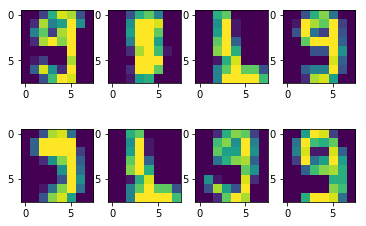

In [147]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=9)

In [148]:
# reshape input as image
train_x = np.reshape(train_x, [len(train_y), 8, 8])
print('train_x shape', train_x.shape)
test_x = np.reshape(test_x, [len(test_y), 8, 8])
print('test_x shape', test_x.shape)

train_x shape (326, 8, 8)
test_x shape (36, 8, 8)


In [149]:
# we will make matrixes now and feed them into QCNN
train_x = np.array([make_matrixes_4x4(x, 8) for x in train_x])
print(train_x.shape)
test_x = np.array([make_matrixes_4x4(x, 8) for x in test_x])
print(test_x.shape)

(326, 9, 16)
(36, 9, 16)


In [150]:
lr = 0.035
steps = 100
batch_size = 2

hyperparams = {'circuit': circuit,
               'task': 'supervised',
               'loss': myloss,
               'optimizer': 'SGD',
               'init_learning_rate': lr,
               'log_every': 1,
               'warm_start': False}

print('trainX = {}'.format(train_x.shape))

learner = CircuitLearner(hyperparams=hyperparams)

learner.train_circuit(X=train_x, Y=train_y, steps=steps, batch_size=batch_size)

test_score = learner.score_circuit(X=test_x, Y=test_y,
                                   outputs_to_predictions=outputs_to_predictions)

test_acc.append(test_score['accuracy'])
test_loss.append(test_score['loss'])

trainX = (326, 9, 16)

----------------------------- 
 HYPERPARAMETERS: 

batch_size - None (default value)
circuit - User defined function.
decay - 0.0 (default value)
init_learning_rate - 0.035
log_every - 1
loss - User defined function.
model_dir - None (default value)
optimizer - SGD
outputs_to_predictions - None (default value)
plot_every - 1 (default value)
print_log - True (default value)
regularization_strength - 0.1 (default value)
regularizer - No regularizer provided.
task - supervised
warm_start - False

 -----------------------------
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_task_type': 'worker', '_save_summary_steps': 100, '_log_step_count_steps': 100, '_is_chief': True, '_session_config': None, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fee67797fd0>, '_master': '', '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'logs

InvalidArgumentError: TensorArray dtype is double but Op is trying to write dtype float.
	 [[Node: map/while/TensorArrayWrite/TensorArrayWriteV3 = TensorArrayWriteV3[T=DT_FLOAT, _class=["loc:@map/while/truediv"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](map/while/TensorArrayWrite/TensorArrayWriteV3/Enter, map/while/Identity, map/while/truediv, map/while/Switch_1:1)]]
	 [[Node: OptimizeLoss/gradients/map/while/Rotation_5/stack_1_grad/tuple/group_deps/_3046 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_21411...group_deps", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_cloopOptimizeLoss/gradients/map/while/Rotation/MatrixSetDiag_grad/zeros/_289)]]

Caused by op 'map/while/TensorArrayWrite/TensorArrayWriteV3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 162, in _fake_ctx_run
    return f(*args, **kw)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-150-5ef9cf65a141>", line 17, in <module>
    learner.train_circuit(X=train_x, Y=train_y, steps=steps, batch_size=batch_size)
  File "/usr/local/lib/python3.5/dist-packages/qmlt/tf/learner.py", line 561, in train_circuit
    self.train(input_fn=input_fn, hooks=myhooks, steps=steps)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 352, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 812, in _train_model
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/estimator/estimator.py", line 793, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/qmlt/tf/learner.py", line 504, in _model_fn
    mode=mode)
  File "/usr/local/lib/python3.5/dist-packages/qmlt/tf/learner.py", line 345, in _qcv_model_fn
    outps = circuit(X=X)
  File "<ipython-input-146-8fdb2e7faab8>", line 155, in circuit
    return single_circuit(X)
  File "<ipython-input-146-8fdb2e7faab8>", line 151, in single_circuit
    _x = tf.map_fn(lambda x: conv_4x4_layer(x, params), input_x)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/functional_ops.py", line 413, in map_fn
    swap_memory=swap_memory)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 3096, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2874, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py", line 2814, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/functional_ops.py", line 406, in compute
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_fn_values)]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/functional_ops.py", line 406, in <listcomp>
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_fn_values)]
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/tensor_array_ops.py", line 879, in write
    return self._implementation.write(index, value, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_should_use.py", line 118, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/tensor_array_ops.py", line 278, in write
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 5071, in _tensor_array_write_v3
    flow_in=flow_in, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): TensorArray dtype is double but Op is trying to write dtype float.
	 [[Node: map/while/TensorArrayWrite/TensorArrayWriteV3 = TensorArrayWriteV3[T=DT_FLOAT, _class=["loc:@map/while/truediv"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](map/while/TensorArrayWrite/TensorArrayWriteV3/Enter, map/while/Identity, map/while/truediv, map/while/Switch_1:1)]]
	 [[Node: OptimizeLoss/gradients/map/while/Rotation_5/stack_1_grad/tuple/group_deps/_3046 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_21411...group_deps", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](^_cloopOptimizeLoss/gradients/map/while/Rotation/MatrixSetDiag_grad/zeros/_289)]]


In [ ]:
tensors = tf.constant(train_x)

In [ ]:
tensors.shape[0].